In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')
sns.set()

In [18]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', encoding = "ISO-8859-1", header=0,\
                       dtype={'name': 'str',\
                              'department': 'category',\
                              'title': 'category',\
                              'year': 'category',\
                              'dept_clean': 'category',\
                              'title_clean': 'category'})
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 16 columns):
Unnamed: 0     152544 non-null int64
name           152544 non-null object
department     152544 non-null category
title          152544 non-null category
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zipcode        152544 non-null object
year           152544 non-null category
dept_clean     152544 non-null category
title_clean    152544 non-null category
dtypes: category(5), float64(8), int64(1), object(2)
memory usage: 14.2+ MB


      total payroll ($)
year                   
2011       1.297467e+09
2012       1.315063e+09
2013       1.384350e+09
2014       1.487853e+09
2015       1.551892e+09
2016       1.580210e+09
2017       1.590906e+09


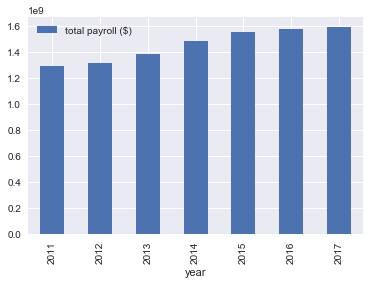

In [7]:
total_earnings = earnings.groupby(earnings['year'])['total']\
                        .agg(np.sum)\
                        .reset_index()\
                        .set_index('year')\
                        .rename(columns={'total':'total payroll ($)'})
print(total_earnings)
total_earnings.plot(kind='bar')
plt.show()

In [9]:
# Median earnings by department for 2016. Small departments are excluded for better statistics.

large_depts = earnings[earnings.year == '2017'] \
                    .groupby('dept_clean')[['dept_clean', 'total']] \
                    .filter(lambda x: (x['dept_clean'].agg('count') > 50)) \
                    .reset_index() \
                    .groupby('dept_clean')['total'] \
                    .agg(np.median) \
                    .nlargest(20)
print(large_depts)

dept_clean
Boston Police Department          129707.620
Boston Fire Department            123488.065
Public Facilities Department       94147.145
Dpt of Innovation & Technology     86958.740
Neighborhood Development           75712.495
Inspectional Services Dept         72544.130
Assessing Department               70647.120
Property Management                70068.355
Law Department                     69416.390
Boston Retirement System           67564.160
Public Works Department            58223.695
Mayor's Office                     57671.620
ASD Human Resources                55941.285
Traffic Division                   54284.070
Boston Public Library              54204.800
Boston Public Schools              53277.260
Transportation-Parking Clerk       51843.790
Neighborhood Services              50357.680
Elderly Commission                 47840.215
Parks Department                   43352.655
Name: total, dtype: float64


## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2016?

68 % of city employees live in Boston (2017).


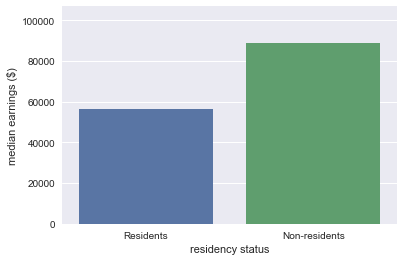

In [19]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"
# boston_zips['bzips'] = boston_zips['bzips'].astype('category')

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zipcode.isin(boston_zips.bzips) & (earnings.year == '2017'))]
outzips = earnings.loc[(~earnings.zipcode.isin(boston_zips.bzips) & (earnings.year == '2017'))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100
print(int(residents), '% of city employees live in Boston (2017).')

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'residency status': ['Residents', 'Non-residents'], 'median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
sns.barplot(x='residency status', y='median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()